# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda')


# b. MNIST Data Loader

In [2]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. PixelCNN**


# a. Training Function

In [3]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                          padding, dilation, groups, bias)
        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type
        self.register_buffer('mask', torch.zeros_like(self.weight))
        k_h, k_w = self.kernel_size
        center_h = k_h // 2
        center_w = k_w // 2

        for h in range(k_h):
            for w in range(k_w):
                if h < center_h:
                    self.mask[:, :, h, w] = 1
                elif h == center_h and w < center_w:
                    self.mask[:, :, h, w] = 1
                elif self.mask_type == 'B' and h == center_h and w == center_w:
                    self.mask[:, :, h, w] = 1

    def forward(self, x):
        masked_weight = self.weight * self.mask
        return F.conv2d(x, masked_weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

# c. Model

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 1),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            MaskedConv2d("B", in_channels // 2, in_channels // 2, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels // 2, in_channels, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        inputs = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return inputs + x

class PixelCNN(nn.Module):
    def __init__(self, input_channels, num_filters, kernel_size, num_layers, num_output_features):
        super(PixelCNN, self).__init__()
        self.input_channels = input_channels
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.num_output_features = num_output_features
        self.layers = nn.ModuleList()

        # Initial masked convolution (Type A)
        self.layers.append(MaskedConv2d('A', input_channels, num_filters, kernel_size, padding=kernel_size // 2))
        self.layers.append(nn.ReLU())
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_filters) for _ in range(self.num_layers)]
        )

        # Intermediate masked convolutions (Type B)
        for _ in range(num_layers - 2):
            self.layers.append(MaskedConv2d('B', num_filters, num_filters, kernel_size, padding=kernel_size // 2))
            self.layers.append(nn.ReLU())

        # Output layers
        self.layers.append(MaskedConv2d('B', num_filters, num_filters, 1))
        self.layers.append(nn.ReLU())
        self.layers.append(MaskedConv2d('B', num_filters, num_output_features, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return self.sigmoid(out)

# d. Training

In [6]:
##################
### Problem 2(c): Training
epochs = 20
model = PixelCNN(1,64,7,5,1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

log = train(train_loader, model, optimizer, epochs)
##################


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/20], Average Loss: 0.1351



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/20], Average Loss: 0.0887



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/20], Average Loss: 0.0863



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/20], Average Loss: 0.0850



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/20], Average Loss: 0.0841



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/20], Average Loss: 0.0835



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/20], Average Loss: 0.0830



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/20], Average Loss: 0.0825



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/20], Average Loss: 0.0821



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/20], Average Loss: 0.0818



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/20], Average Loss: 0.0815



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/20], Average Loss: 0.0813



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/20], Average Loss: 0.0810



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/20], Average Loss: 0.0807



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/20], Average Loss: 0.0805



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/20], Average Loss: 0.0803



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/20], Average Loss: 0.0802



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/20], Average Loss: 0.0800



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/20], Average Loss: 0.0798



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/20], Average Loss: 0.0797



# e. Evaluation (Reconstruction)

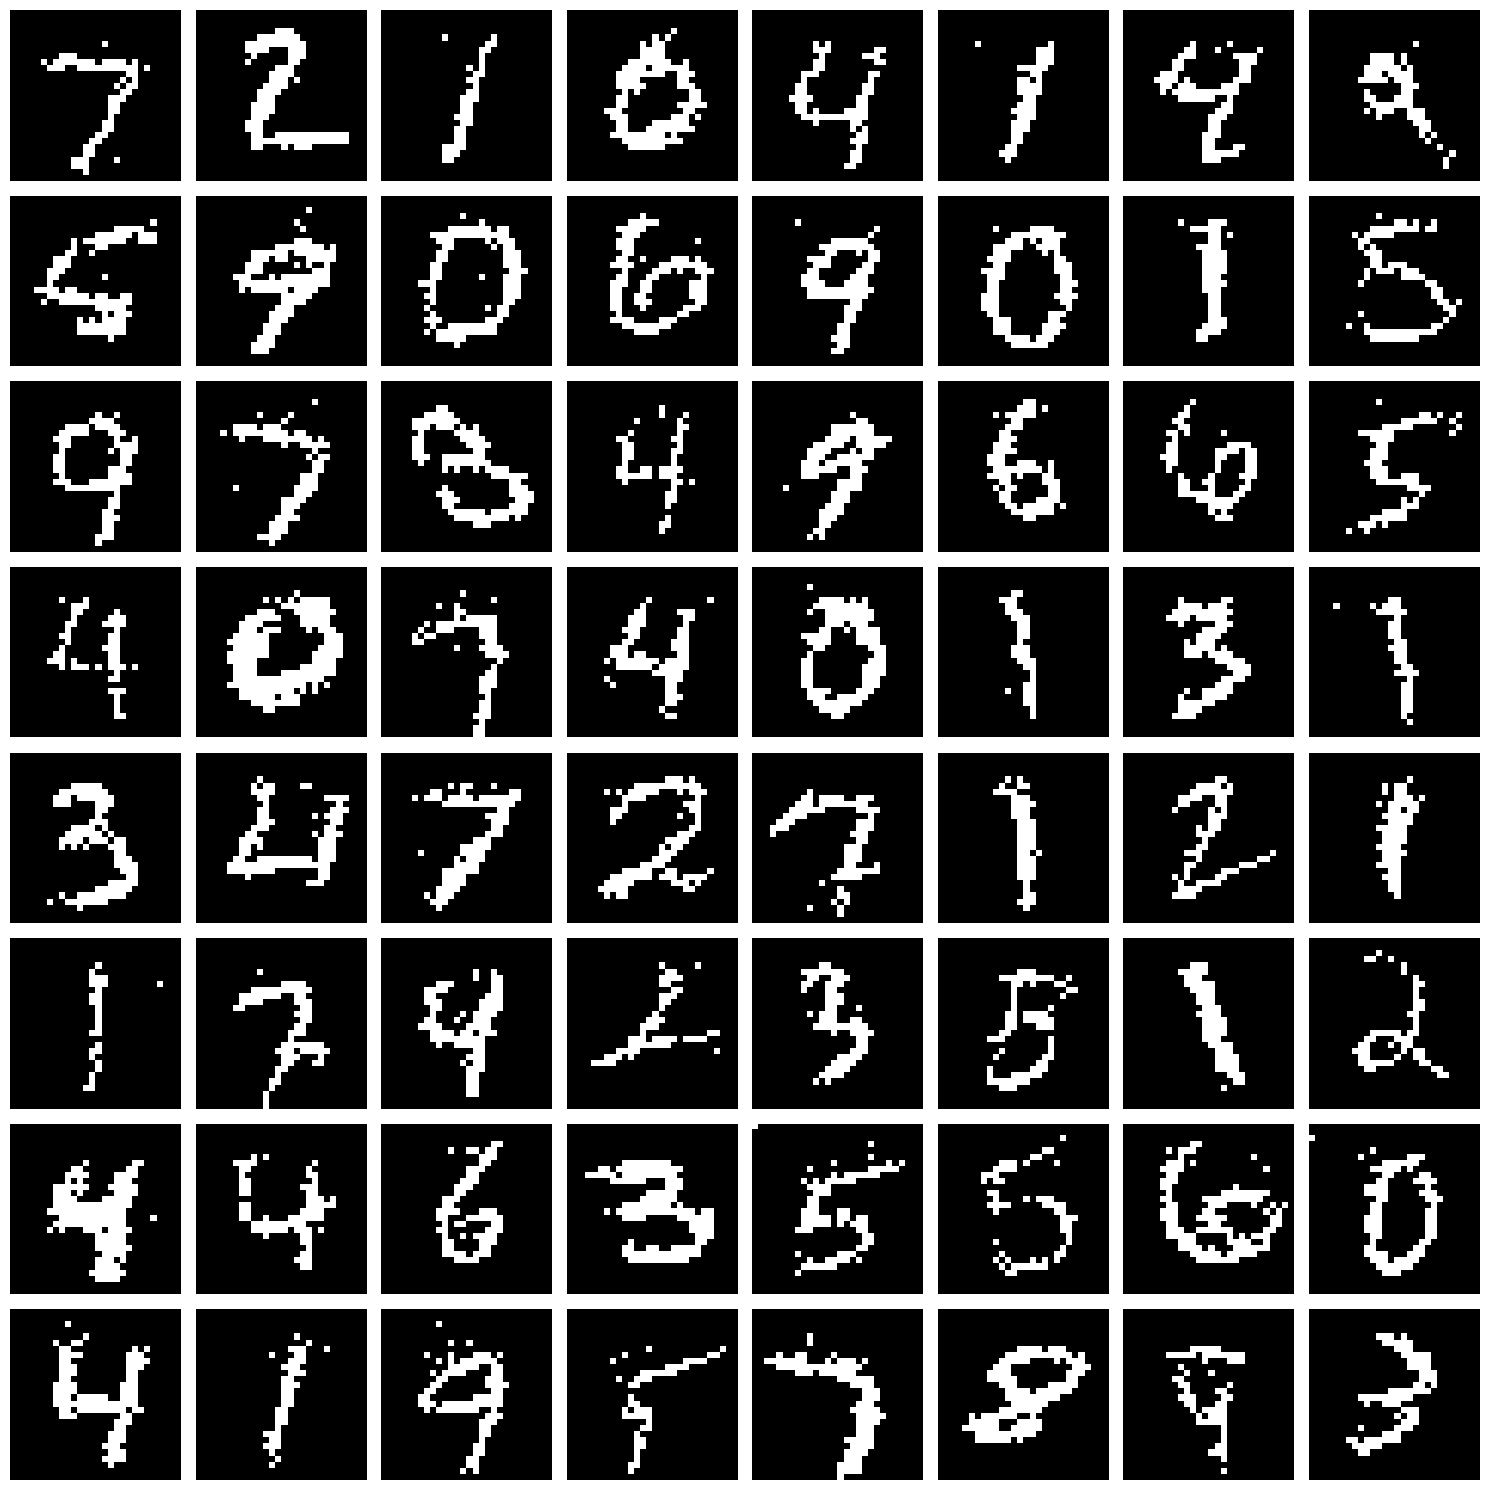

In [7]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

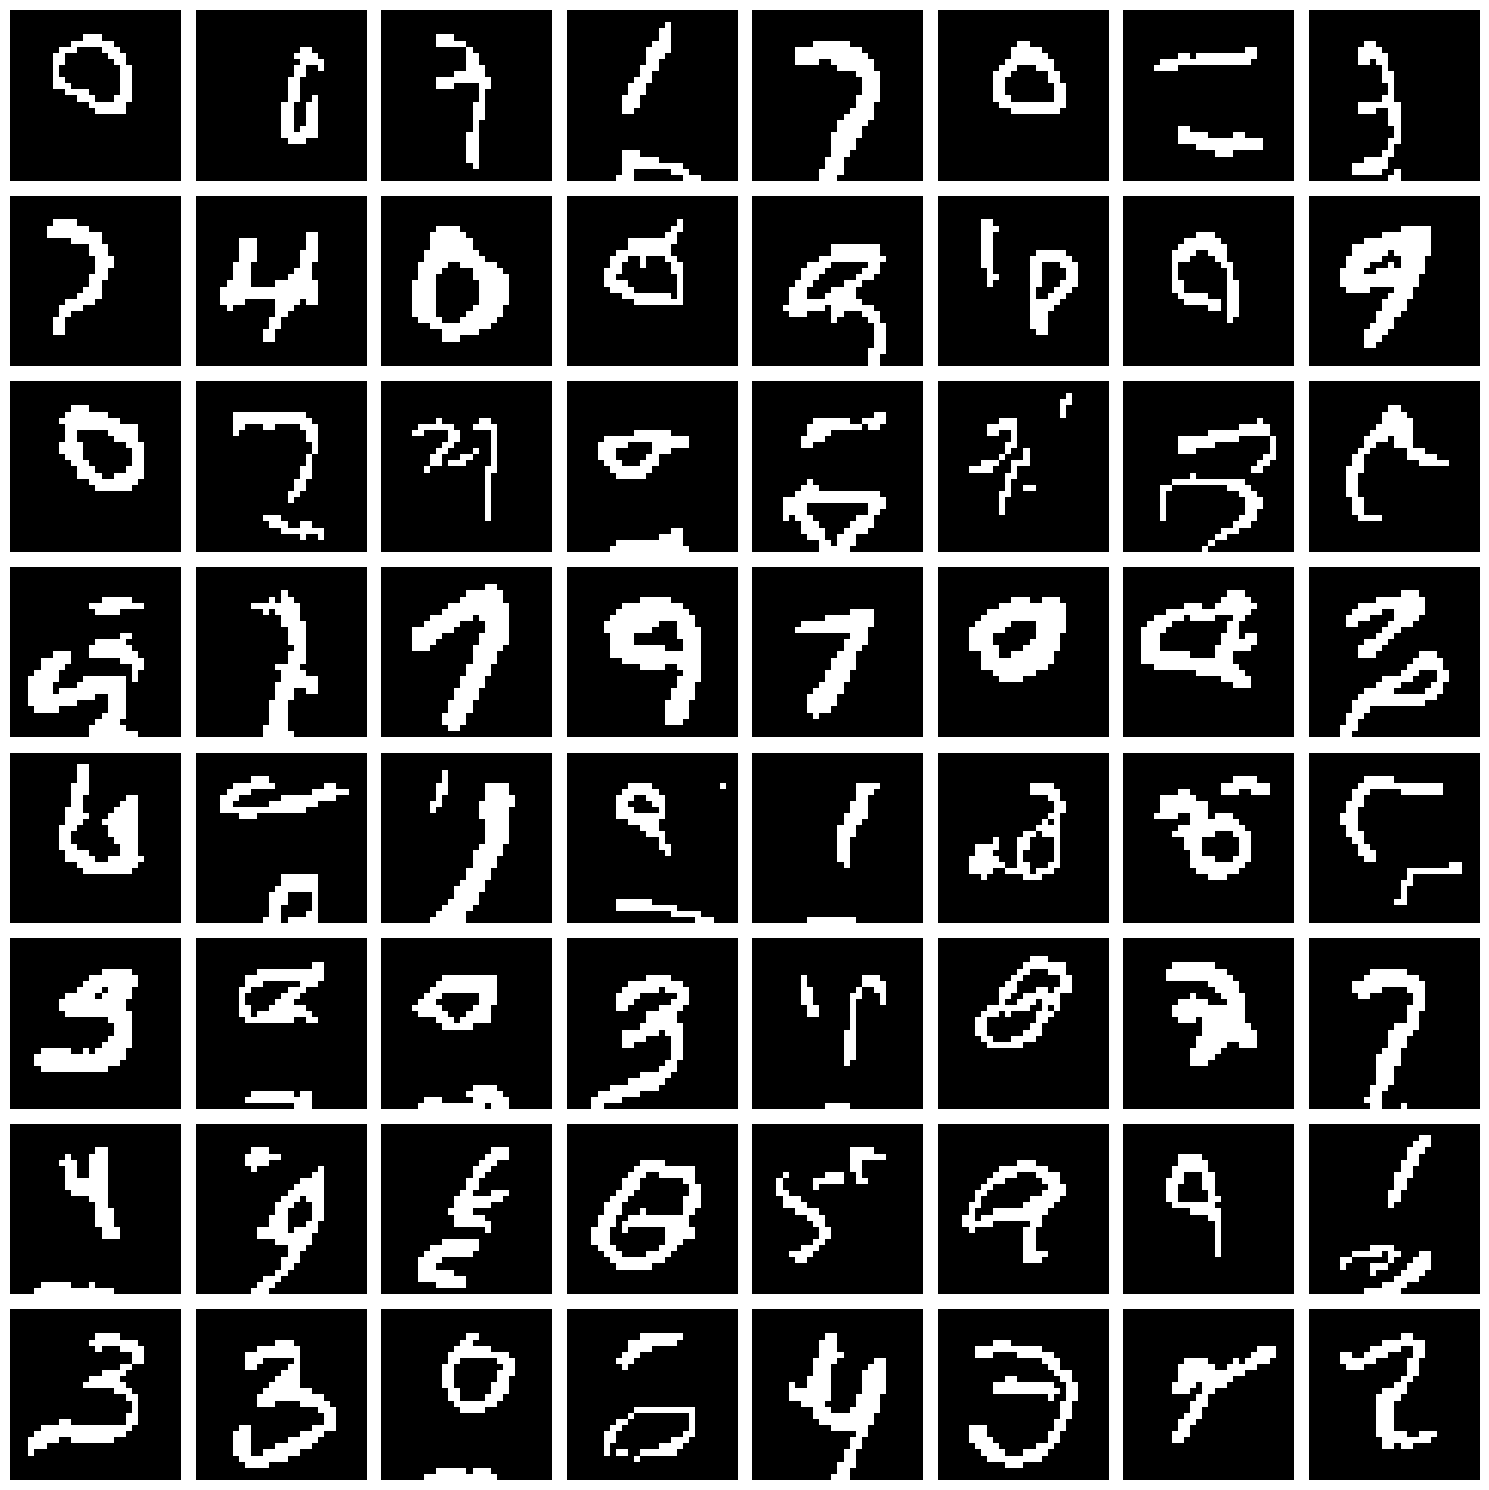

In [8]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [9]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [10]:
class ConditionalMaskedConv2d(MaskedConv2d):
    ##################
    ### Problem 3(a): Implement ConditionalMaskedConv2d
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, num_classes=10):
        super().__init__(mask_type, in_channels, out_channels, kernel_size, stride,
                         padding, dilation, groups, bias)
        self.num_classes = num_classes
        self.conditional_bias = nn.Parameter(torch.zeros(out_channels, num_classes))

    def forward(self, x, class_condition):
        output = super().forward(x)
        conditional_bias = torch.matmul(self.conditional_bias, class_condition.transpose(0, 1)).transpose(0, 1)
        conditional_bias = conditional_bias.unsqueeze(2).unsqueeze(3)  # For broadcasting
        return output + conditional_bias
    ##################

# c. Model

In [11]:
class ConditionalPixelCNN(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalPixelCNN
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = ConditionalMaskedConv2d('A', 1, 128, kernel_size=7, padding=3, num_classes=num_classes)
        self.conv2 = ConditionalMaskedConv2d('B', 128, 128, kernel_size=3, padding=1, num_classes=num_classes)
        self.conv3 = ConditionalMaskedConv2d('B', 128, 128, kernel_size=3, padding=1, num_classes=num_classes)
        self.conv4 = ConditionalMaskedConv2d('B', 128, 128, kernel_size=3, padding=1, num_classes=num_classes)
        self.conv5 = ConditionalMaskedConv2d('B', 128, 128, kernel_size=3, padding=1, num_classes=num_classes)
        self.conv6 = nn.Conv2d(128, 1, kernel_size=1)

    def forward(self, x, class_condition):
        x = F.relu(self.conv1(x, class_condition))
        x = F.relu(self.conv2(x, class_condition))
        x = F.relu(self.conv3(x, class_condition))
        x = F.relu(self.conv4(x, class_condition))
        x = F.relu(self.conv5(x, class_condition))
        return torch.sigmoid(self.conv6(x))
    ##################

# d. Training

In [12]:
##################
epochs = 20
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [1/20], Average Loss: 0.1219



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [2/20], Average Loss: 0.0879



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3/20], Average Loss: 0.0855



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [4/20], Average Loss: 0.0842



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [5/20], Average Loss: 0.0834



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [6/20], Average Loss: 0.0829



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [7/20], Average Loss: 0.0825



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [8/20], Average Loss: 0.0820



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [9/20], Average Loss: 0.0818



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [10/20], Average Loss: 0.0814



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [11/20], Average Loss: 0.0812



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [12/20], Average Loss: 0.0810



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [13/20], Average Loss: 0.0807



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [14/20], Average Loss: 0.0805



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [15/20], Average Loss: 0.0803



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [16/20], Average Loss: 0.0802



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [17/20], Average Loss: 0.0800



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [18/20], Average Loss: 0.0799



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [19/20], Average Loss: 0.0797



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [20/20], Average Loss: 0.0797



# e. Evaluation (Reconstruction)

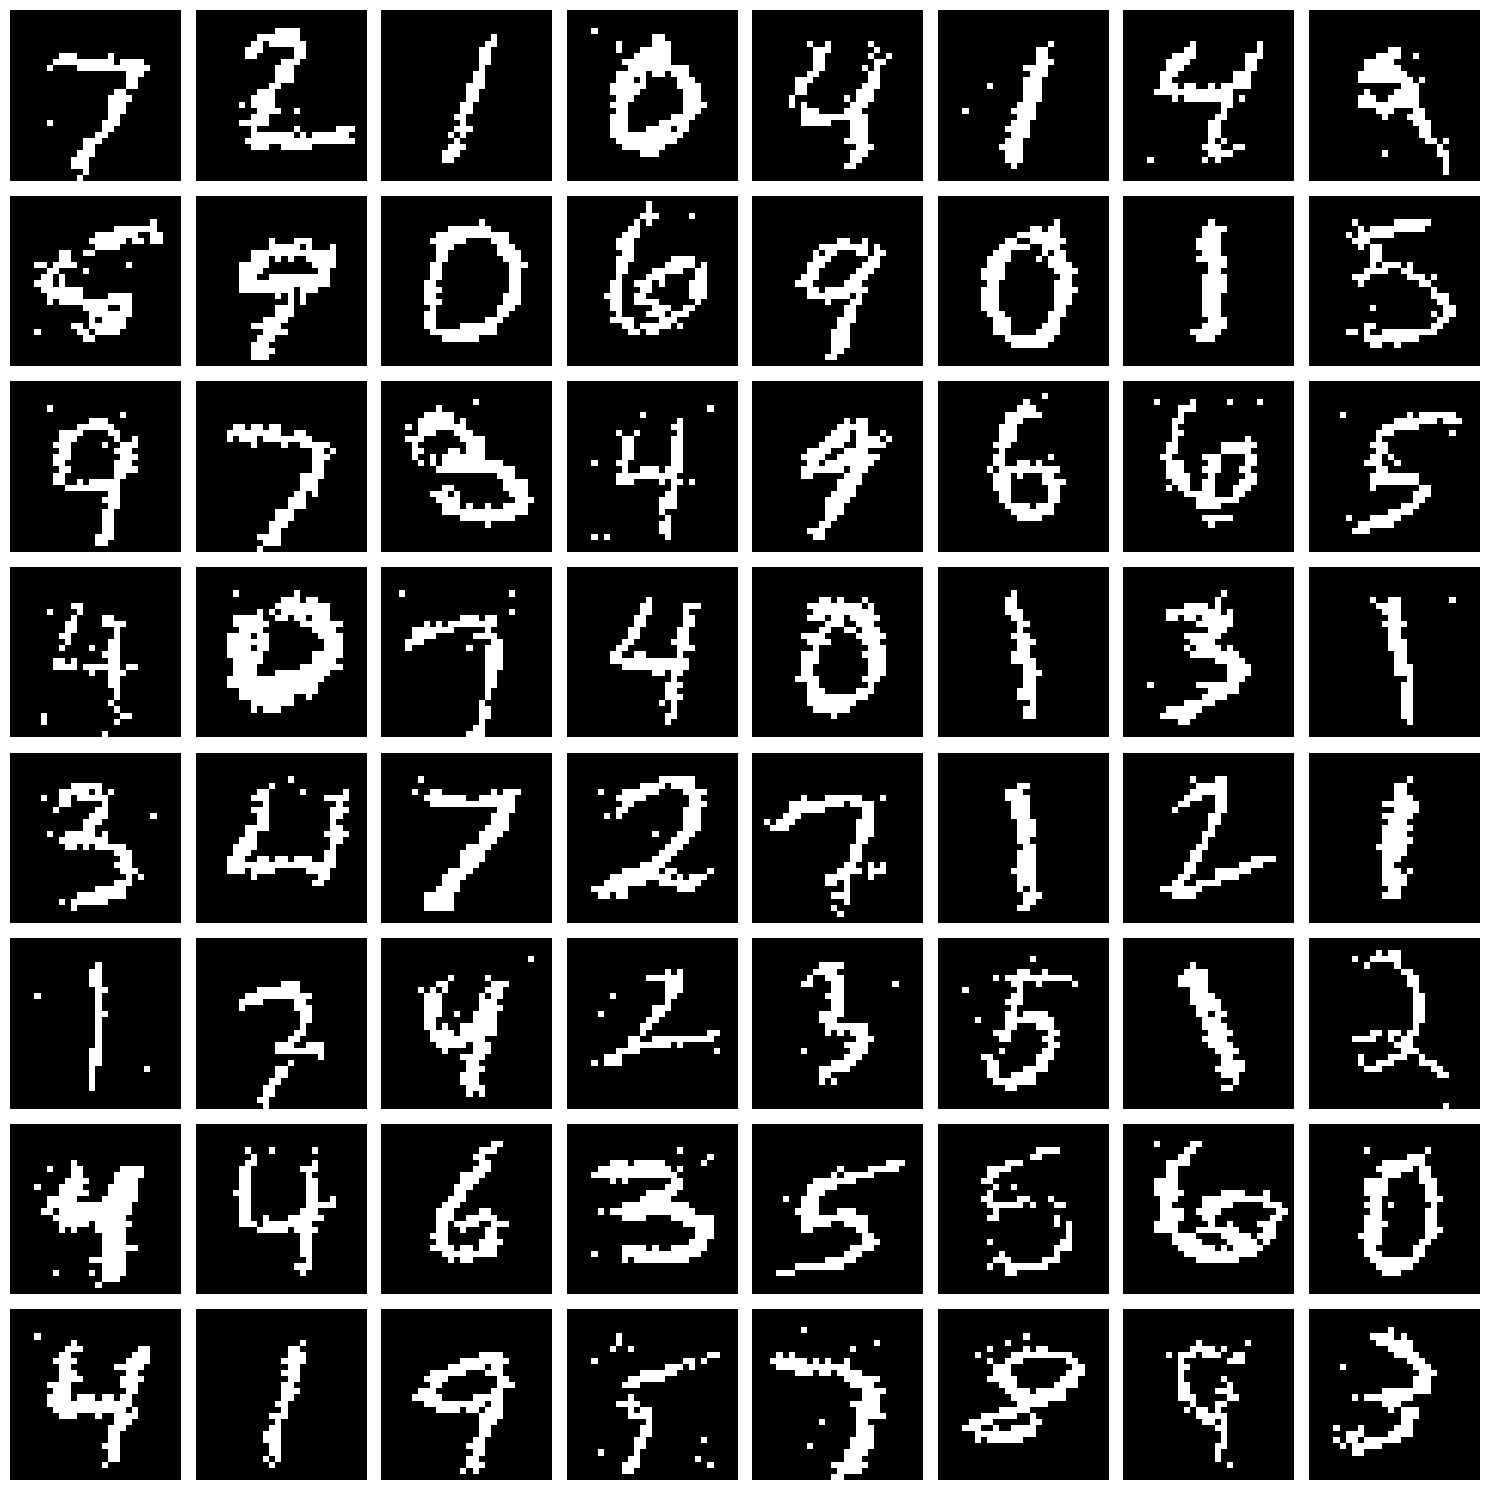

In [13]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

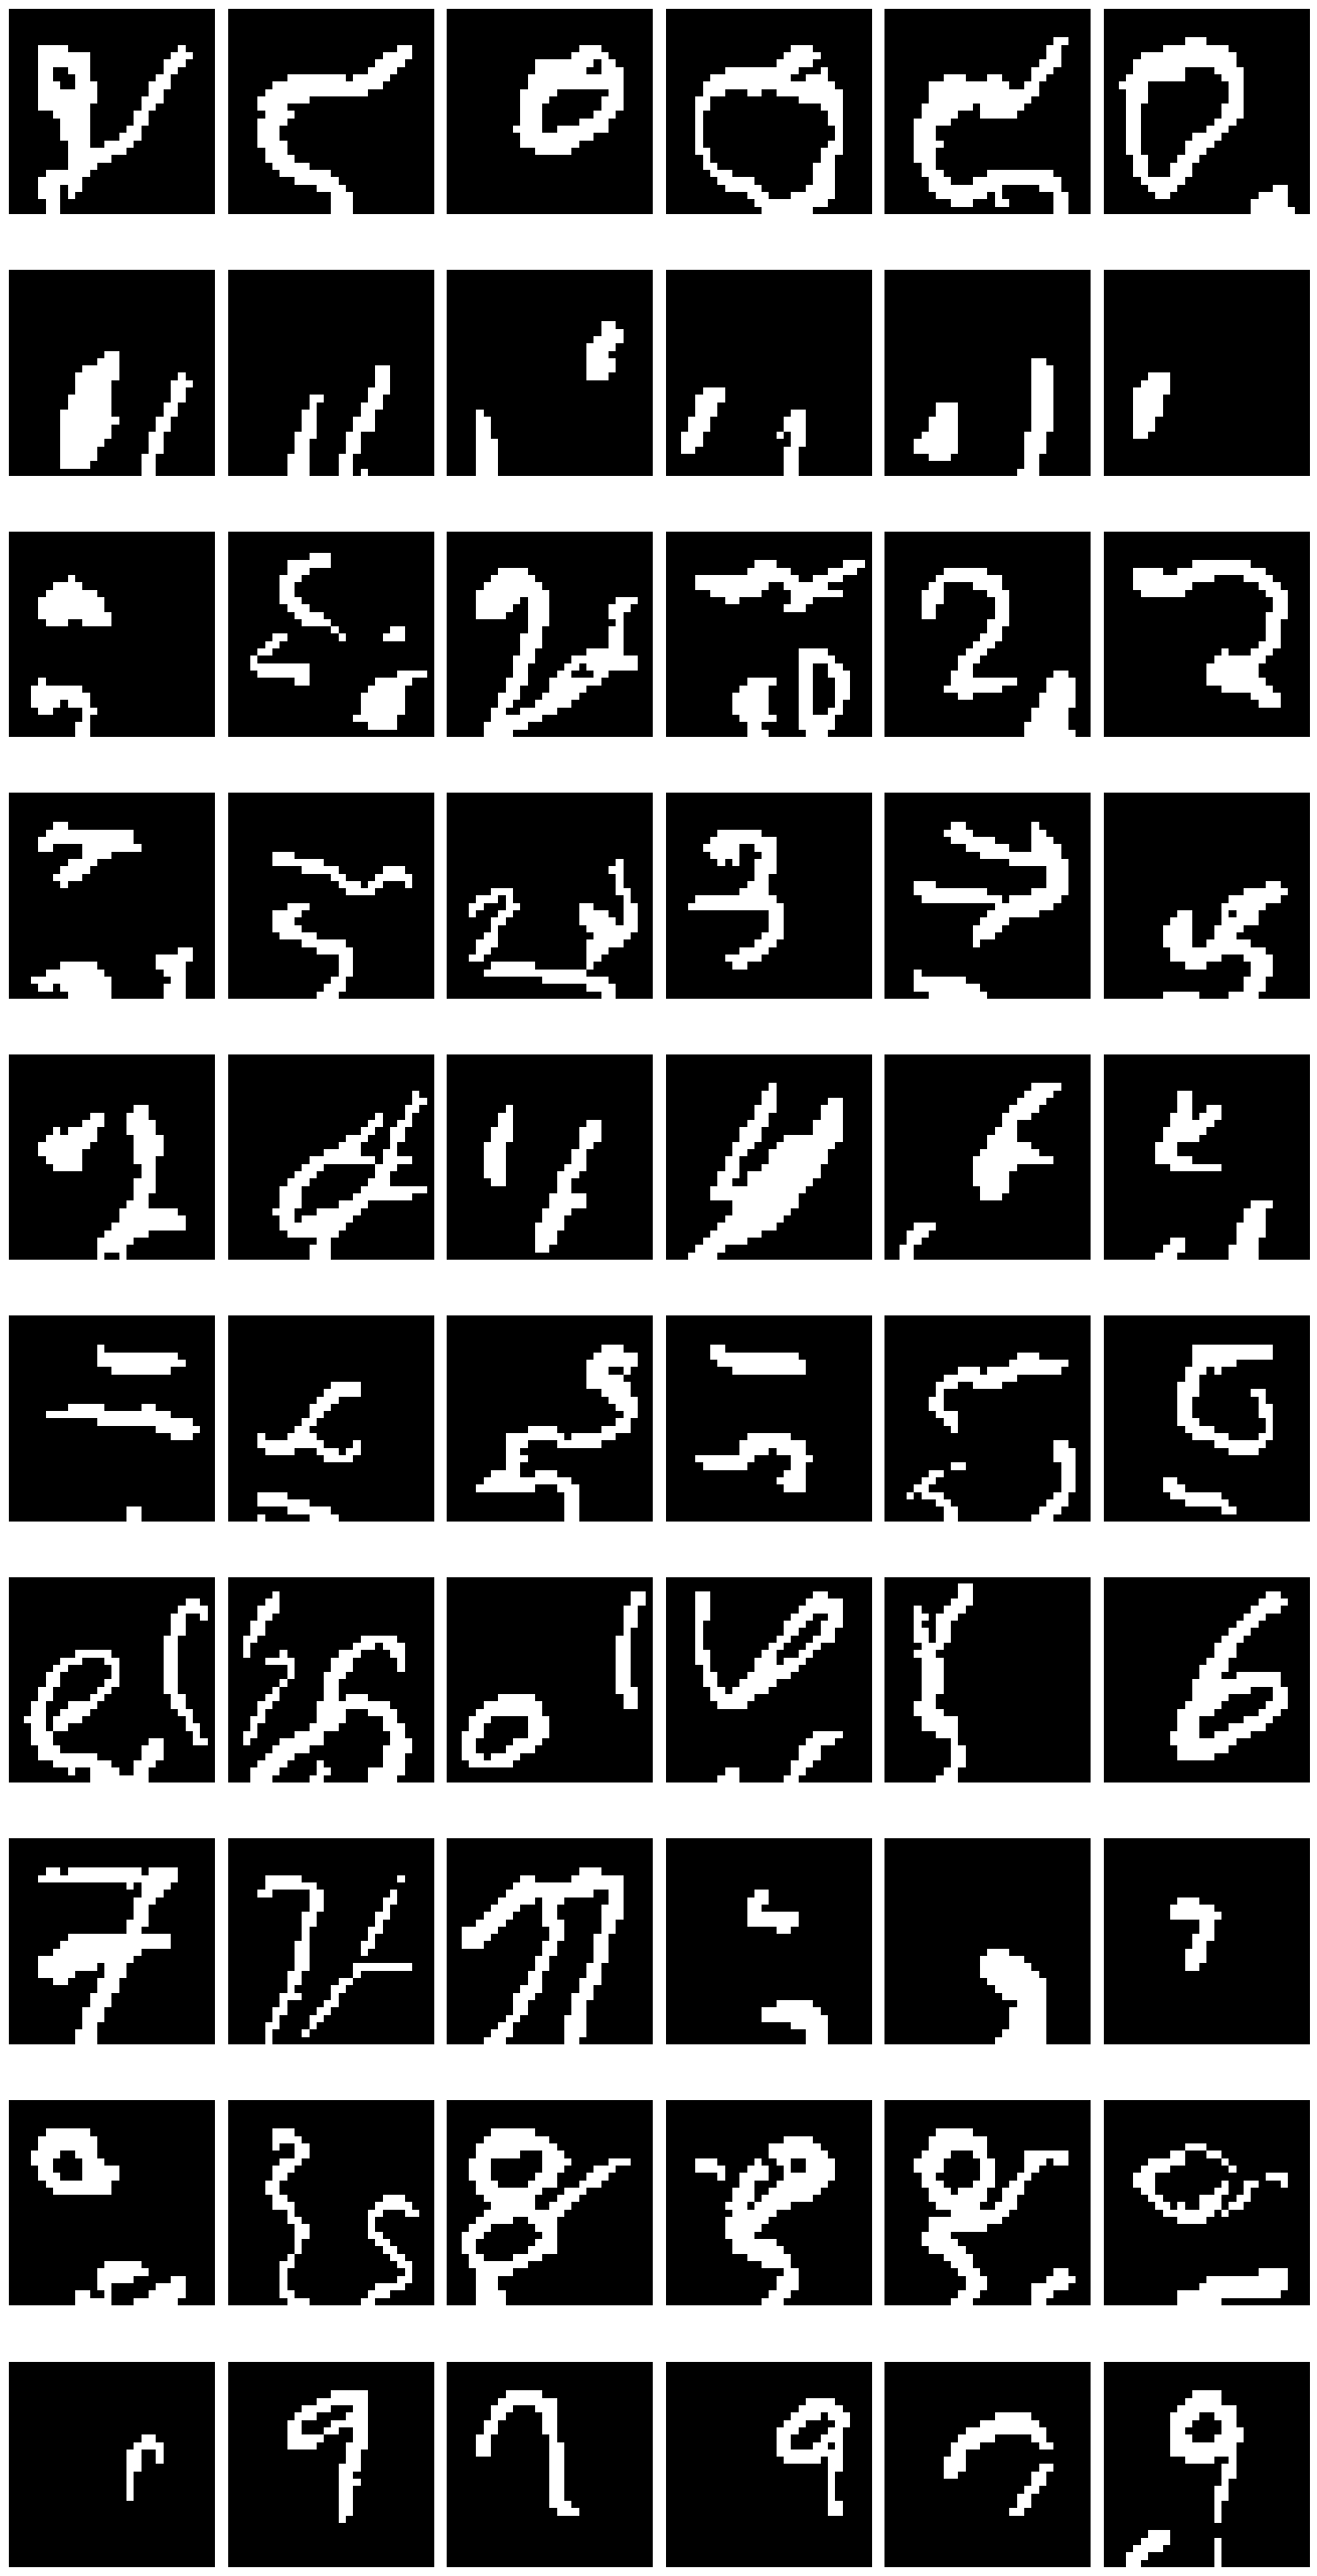

In [14]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.tensor(sample_classes).long(), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()